# Word Embedding

자연어차리는 언어데이터를 기반으로 정보를 추출하고 분석, 활용하는 기술
- 분석 단위 설정: 토큰화(Tokenize)
- 불필요한 단어 제거: 스토핑(Stopping)
> a, the, 은, 는, 이, 가
- 단어의 형태 고려: 스테밍(Stemming)
> ed, ing, 하다, 했다, 할 것이다


이렇게 전처리 한 후 어떻게 해야할까?
> Word Embedding(단어를 벡터화 하는 것)
- Bag of Words
- Word2Vec

In [1]:
import torch
import torch.nn as nn

In [2]:
train_data = '우리은행 분석방법론 과정 딥러닝 수업 시간입니다'

In [3]:
word_set = set(train_data.split())

In [4]:
vocab = {word: i+2 for i, word in enumerate(word_set)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1
print(vocab)

{'딥러닝': 2, '수업': 3, '과정': 4, '시간입니다': 5, '분석방법론': 6, '우리은행': 7, '<unk>': 0, '<pad>': 1}


In [5]:
len(vocab)

8

In [6]:
embedding_table = torch.FloatTensor([
                               [ 0.0,  0.0,  0.0],
                               [ 0.0,  0.0,  0.0],
                               [ 0.2,  0.9,  0.3],
                               [ 0.1,  0.5,  0.7],
                               [ 0.2,  0.1,  0.8],
                               [ 0.4,  0.1,  0.1],
                               [ 0.1,  0.8,  0.9],
                               [ 0.6,  0.1,  0.1]])

In [7]:
sample = '분석방법론 과정 수업 재밌습니다'.split()
idxes = []

# 각 단어를 정수로 변환
for word in sample:
  try:
    idxes.append(vocab[word])
  # 단어 집합에 없는 단어일 경우 <unk>로 대체된다.
  except KeyError:
    idxes.append(vocab['<unk>'])
idxes = torch.LongTensor(idxes)

# 각 정수를 인덱스로 임베딩 테이블에서 값을 가져온다.
lookup_result = embedding_table[idxes, :]
print(lookup_result)

tensor([[0.1000, 0.8000, 0.9000],
        [0.2000, 0.1000, 0.8000],
        [0.1000, 0.5000, 0.7000],
        [0.0000, 0.0000, 0.0000]])


nn.Embedding 사용

In [8]:
train_data = '우리은행 분석방법론 과정 딥러닝 수업 시간입니다'

# 중복을 제거한 단어들의 집합인 단어 집합 생성.
word_set = set(train_data.split())

# 단어 집합의 각 단어에 고유한 정수 맵핑.
vocab = {tkn: i+2 for i, tkn in enumerate(word_set)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1

In [9]:
embedding_layer = nn.Embedding(num_embeddings=len(vocab), 
                               embedding_dim=3,
                               padding_idx=1)

In [10]:
print(embedding_layer.weight)


Parameter containing:
tensor([[ 0.2697, -0.1325, -0.9139],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.4033, -0.0464, -0.5298],
        [-1.0094,  1.1307, -0.6061],
        [ 0.0093,  0.1555,  0.1342],
        [ 0.5497, -0.0530,  0.5141],
        [-0.2408,  0.9198, -1.5051],
        [ 0.1743,  2.3252,  0.8855]], requires_grad=True)


## Bag of Words

In [11]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 67.6 MB/s 
     |████████████████████████████████| 448 kB 69.1 MB/s 


In [13]:
from konlpy.tag import Okt

okt = Okt()

def build_bag_of_words(document):
  # 온점 제거 및 형태소 분석
  document = document.replace('.', '')
  tokenized_document = okt.morphs(document)

  word_to_index = {}
  bow = []

  for word in tokenized_document:  
    if word not in word_to_index.keys():
      word_to_index[word] = len(word_to_index)  
      # BoW에 전부 기본값 1을 넣는다.
      bow.insert(len(word_to_index) - 1, 1)
    else:
      # 재등장하는 단어의 인덱스
      index = word_to_index.get(word)
      # 재등장한 단어는 해당하는 인덱스의 위치에 1을 더한다.
      bow[index] = bow[index] + 1

  return word_to_index, bow

In [14]:
doc1 = "정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다."
vocab, bow = build_bag_of_words(doc1)
print('vocabulary :', vocab)
print('bag of words vector :', bow)

vocabulary : {'정부': 0, '가': 1, '발표': 2, '하는': 3, '물가상승률': 4, '과': 5, '소비자': 6, '느끼는': 7, '은': 8, '다르다': 9}
bag of words vector : [1, 2, 1, 1, 2, 1, 1, 1, 1, 1]


In [15]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

## TF-IDF

TF-IDF란 출현 빈도를 사용해 어떤 단어가 문서내에서 얼마나 중요한지 나타내는 수치이다.
TF-IDF가 높을수록 그 단어가 문서를 대표하는 성질을 띈다고 할 수 있다.
- TF(term frequency): 문서 내에서 단어가 출현한 횟수
- IDF(inverse document frequency): 단어가 출현한 문서 수의 역수

TF가 높고, IDF가 적을수록 TF-IDF가 높다. 예를 들어 the는 TF가 높지만, the가 출현한 문서도 많기 때문에 그 숫자의 역인 IDF가 작아 문서 내에서 중요하지 않다고 할 수 있다.

In [16]:
import pandas as pd

In [17]:
def get_term_frequency(document, word_dict=None): # 문서 내의 단어들의 출현 빈도
    if word_dict is None:
        word_dict = {}
    words = document.split()
    
    for w in words:
        word_dict[w] = 1 + (0 if word_dict.get(w) is None else word_dict[2])
        
    return pd.Series(word_dict).sort_values(ascending=False)

In [18]:
def get_document_frequency(documents): # 각 단어가 몇 개의 문서에서 나타났는지
    dicts = []
    vocab = set([])
    df = {}
    
    for d in documents:
        tf = get_term_frequency(d)
        dicts += [tf]
        vocab = vocab | set(tf.keys())
        
    for v in list(vocab):
        df[v] = 0
        for dict_d in dicts:
            if dict_d.get(v) is not None:
                df[v] += 1
    
    return pd.Series(df).sort_values(ascending=False)
        

In [19]:
from operator import itemgetter
import numpy as np

In [20]:
def get_tfidf(docs):#TF-IDF 계산
    vocab = {}
    tfs = []
    for d in docs:
        vocab = get_term_frequency(d, vocab)
        tfs += [get_term_frequency(d)]
    df = get_document_frequency(docs)
    
    stats = []
    for word, freq in vocab.items():
        tf_idfs = []
        for idx in range(len(docs)):
            if tfs[idx].get(word) is not None:
                tf_idfs += [tfs[idx][word] * np.log(len(docs) / df[word])]
            else:
                tf_idfs += [0]
                
        stats.append((word, freq, *tf_idfs, max(tf_idfs)))
        
    return pd.DataFrame(stats, columns = ('word',
                                          'frequency',
                                          'doc1',
                                          'doc2',
                                          'doc3',
                                          'max')).sort_values('max', ascending=False)
                

In [21]:
doc1 = "나는 오늘 즐겁다."
doc2 = "너는 오늘 즐겁다."
doc3 = "즐거운 것은 오늘이 아니라 내일이다"

In [22]:
docs = [doc1, doc2, doc3]

In [23]:
get_tfidf(docs)

,word,frequency,doc1,doc2,doc3,max
2,나는,1,1.098612,0.000000,0.000000,1.098612
3,너는,1,0.000000,1.098612,0.000000,1.098612
4,즐거운,1,0.000000,0.000000,1.098612,1.098612
5,것은,1,0.000000,0.000000,1.098612,1.098612
6,오늘이,1,0.000000,0.000000,1.098612,1.098612
7,아니라,1,0.000000,0.000000,1.098612,1.098612
8,내일이다,1,0.000000,0.000000,1.098612,1.098612
0,오늘,2,0.405465,0.405465,0.000000,0.405465
1,즐겁다.,2,0.405465,0.405465,0.000000,0.405465


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'All you need is love',
    'I love you',
    'I think I am in love with you'
]

tfidfv = TfidfVectorizer().fit(corpus)

In [25]:
tfidfv.transform(corpus).toarray()

array([[0.52004008, 0.        , 0.        , 0.52004008, 0.30714405,
        0.52004008, 0.        , 0.        , 0.30714405],
       [0.        , 0.        , 0.        , 0.        , 0.70710678,
        0.        , 0.        , 0.        , 0.70710678],
       [0.        , 0.46138073, 0.46138073, 0.        , 0.27249889,
        0.        , 0.46138073, 0.46138073, 0.27249889]])

In [26]:
tfidfv.vocabulary_

{'all': 0,
 'am': 1,
 'in': 2,
 'is': 3,
 'love': 4,
 'need': 5,
 'think': 6,
 'with': 7,
 'you': 8}

In [27]:
tfidfv_kor = TfidfVectorizer().fit(docs)

In [28]:
tfidfv_kor.transform(docs).toarray()

array([[0.        , 0.68091856, 0.        , 0.        , 0.        ,
        0.51785612, 0.        , 0.        , 0.51785612],
       [0.        , 0.        , 0.        , 0.68091856, 0.        ,
        0.51785612, 0.        , 0.        , 0.51785612],
       [0.4472136 , 0.        , 0.4472136 , 0.        , 0.4472136 ,
        0.        , 0.4472136 , 0.4472136 , 0.        ]])

In [29]:
tfidfv_kor.vocabulary_

{'것은': 0,
 '나는': 1,
 '내일이다': 2,
 '너는': 3,
 '아니라': 4,
 '오늘': 5,
 '오늘이': 6,
 '즐거운': 7,
 '즐겁다': 8}

## N-gram

In [30]:
def custom_ngrams(text, n):
    text = text.split(' ')
    output = []
    for i in range(len(text) - n + 1):
        output.append(text[i:i+n])
    return output

In [31]:
dynamite = 'Cause I\'m in the stars tonight, So watch me bring the fire and set the night alight'

In [32]:
print(custom_ngrams(dynamite, 3))

[['Cause', "I'm", 'in'], ["I'm", 'in', 'the'], ['in', 'the', 'stars'], ['the', 'stars', 'tonight,'], ['stars', 'tonight,', 'So'], ['tonight,', 'So', 'watch'], ['So', 'watch', 'me'], ['watch', 'me', 'bring'], ['me', 'bring', 'the'], ['bring', 'the', 'fire'], ['the', 'fire', 'and'], ['fire', 'and', 'set'], ['and', 'set', 'the'], ['set', 'the', 'night'], ['the', 'night', 'alight']]


In [33]:
from nltk import ngrams

In [34]:
trigram = ngrams(dynamite.split(' '), 3)

In [35]:
print(*trigram)

('Cause', "I'm", 'in') ("I'm", 'in', 'the') ('in', 'the', 'stars') ('the', 'stars', 'tonight,') ('stars', 'tonight,', 'So') ('tonight,', 'So', 'watch') ('So', 'watch', 'me') ('watch', 'me', 'bring') ('me', 'bring', 'the') ('bring', 'the', 'fire') ('the', 'fire', 'and') ('fire', 'and', 'set') ('and', 'set', 'the') ('set', 'the', 'night') ('the', 'night', 'alight')


## Word2Vec

http://w.elnn.kr/search/ 단어간의 유사도 측정

단어를 벡터로 바꿔서 단어간의 연산이 가능하도록 만들었다: 비슷한 위치의 단어는 비슷한 의미를 가진다

In [36]:
from gensim.models import Word2Vec

In [37]:
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
             ['this', 'is', 'the', 'second', 'sentence'],
             ['yet', 'another', 'sentence'],
             ['one', 'more', 'sentence'],
             ['and', 'the', 'final', 'sentence']]
# train model
# 문장을 이용하여 단어와 벡터를 생성한다.
model = Word2Vec(sentences, min_count=1) #min count: 빈도 작은 것은 학습하지 않기 위해서
# summarize the loaded model
print(model)

Word2Vec(vocab=14, size=100, alpha=0.025)


In [38]:
# 단어벡터를 구하고, 단어간 유사도를 확인하다
model_result = model.wv.most_similar("this")
print(model_result)

[('word2vec', 0.13786041736602783), ('for', 0.05737166851758957), ('yet', 0.042202115058898926), ('is', 0.036751508712768555), ('more', 0.02729915827512741), ('another', 0.02101467177271843), ('sentence', 0.017816560342907906), ('first', 0.007963575422763824), ('one', -0.005264729261398315), ('and', -0.013623807579278946)]


In [39]:
model.wv.most_similar("this")

[('word2vec', 0.13786041736602783),
 ('for', 0.05737166851758957),
 ('yet', 0.042202115058898926),
 ('is', 0.036751508712768555),
 ('more', 0.02729915827512741),
 ('another', 0.02101467177271843),
 ('sentence', 0.017816560342907906),
 ('first', 0.007963575422763824),
 ('one', -0.005264729261398315),
 ('and', -0.013623807579278946)]

In [40]:
model.wv.similarity(w1='first', w2='second')

0.06949833

In [41]:
import gensim.downloader

In [42]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


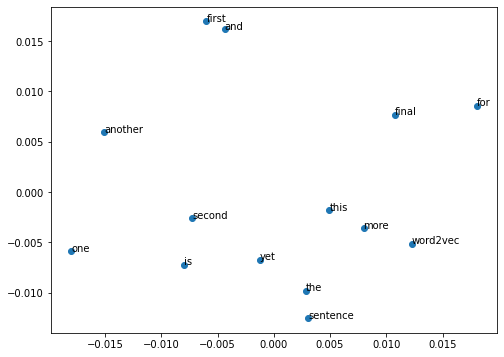

In [43]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
 
# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(8 ,6))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))
 
 
# 단어벡터를 구한다.
word_vectors = model.wv
 
vocabs            = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]
 
plot_2d_graph(vocabs, xs, ys)